In [1]:
source("../src/utils/custom_tools.R")
setup_environment("../src/utils")

In [2]:
impact <- read.table("../data/final_IMPACT_mutations_180508.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [1]:
impact_annotated <- read.table("../data/annotate_with_click_annotvcf/click_annotvcf_IMPACT_mutations_180508.txt",
                               sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")

# Current

In [2]:
impact_annotated <- impact_annotated[impact_annotated$VEP_Consequence %in% c("missense_variant",
                                              "frameshift_variant",
                                               "stop_gained",
                                               "splice_acceptor_variant",
                                               "inframe_deletion",
                                               "splice_donor_variant",
                                               "inframe_insertion",
                                               "start_lost",
                                               "stop_lost"),]

In [ ]:
get_HGVSp_from_vep <- function(HGVSp_string) {
    
    if (is.na(HGVSp_string) | HGVSp_string == "unknown")
        return ("unknown")
    
    HGVSp_string <- strsplit(HGVSp_string, ':')[[1]][2]
    
    protein_long_name <- c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Glu', 'Gln', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                           'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
    protein_short_name <- c('A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K',
                            'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    for (name in protein_long_name)
        HGVSp_string <- gsub(name, protein_short_name[match(name, protein_long_name)], HGVSp_string)
    
    HGVSp_string <- gsub('Ter', '*', HGVSp_string)
    HGVSp_string <- gsub('%3D', '=', HGVSp_string)
    
    return (HGVSp_string)
}

impact_annotated$VEP_HGVSp <- sapply(impact_annotated$VEP_HGVSp, get_HGVSp_from_vep)

impact_annotated$VEP_HGVSc <- sapply(impact_annotated$VEP_HGVSc, function(x) strsplit(x, ':')[[1]][2])

* VEP COSMIC: 81

...

* CUSTOM VEP COSMIC_GENE: Gene name
* CUSTOM VEP COSMIC_STRAND: Gene strand
* CUSTOM VEP COSMIC_CDS: CDS annotation
* CUSTOM VEP COSMIC_AA: Peptide annotation
* CUSTOM VEP COSMIC_CNT: How many samples have this mutation
* CUSTOM VEP COSMIC_SNP: classified as SNP

In [ ]:
head(unique(impact_annotated[! is.na(impact_annotated$VEP_COSMIC) & impact_annotated$VEP_SYMBOL == "CDKN2A",c("VEP_Feature", "VEP_SYMBOL", "VEP_HGVSc", "VEP_HGVSp", "VEP_COSMIC", "VEP_COSMIC_GENE", "VEP_COSMIC_STRAND", "VEP_COSMIC_CDS", "VEP_COSMIC_AA", "VEP_COSMIC_CNT")]), 60)

In [ ]:
head(impact_annotated[,c("VEP_Feature", "VEP_SYMBOL", "VEP_HGVSc", "VEP_HGVSp", "VEP_COSMIC", "VEP_COSMIC_GENE", "VEP_COSMIC_STRAND", "VEP_COSMIC_CDS", "VEP_COSMIC_AA", "VEP_COSMIC_CNT")])

In [ ]:
get_cosmic_count_from_custom_vep <- function(data) {
    
    if (is.na(data["VEP_COSMIC_GENE"]) | is.na(data["VEP_Feature"]) | is.na(data["VEP_COSMIC_CNT"]) | is.na(data["VEP_Feature"]))
        return (0)
    
    transcripts <- strsplit(data["VEP_COSMIC_GENE"], '&')[[1]]
    cosmic_counts <- strsplit(data["VEP_COSMIC_CNT"], '&')[[1]]
    
    
    index <- grep(data["VEP_Feature"], transcripts)
    
    if (length(index) == 0)
        return (0)
    else
        return (cosmic_counts[index])
}

In [ ]:
impact_annotated$cosmic <- apply(impact_annotated, 1, get_cosmic_count_from_custom_vep)

In [ ]:
head(unique(impact_annotated[! is.na(impact_annotated$VEP_COSMIC) & impact_annotated$VEP_SYMBOL == "CDKN2A",c("VEP_Feature", "VEP_SYMBOL", "VEP_COSMIC_GENE", "VEP_COSMIC_CNT", "cosmic")]), 60)

### `Kaviar_AF`

In [66]:
impact_cosmic <- read.table("../data/dominik/all_IMPACT_mutations_180508.simple.hg19_multianno.txt",
                            sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [67]:
# create the impact_kaviar join_key
impact_cosmic$join_key <- paste(impact_cosmic$Chr,
                                impact_cosmic$Start,
                                impact_cosmic$Ref,
                                impact_cosmic$Alt,
                                sep = '_')

**Verification 1** The feature `cosmic70` is unique for each `join_key`:

In [68]:
impact_cosmic <- unique(impact_cosmic[, c("join_key", "cosmic70")])
impact_cosmic %>% group_by(join_key) %>% filter(n() > 1)

join_key,cosmic70


**Verification 2** Every impact `mut_key` has an analoguous `join_key` in `impact_cosmic`:

In [73]:
nrow(impact_annotated[! impact_annotated$ID_VARIANT %in% impact_cosmic$join_key,])

[1] 17396

In [75]:
impact_annotated <- left_join(impact_annotated, impact_cosmic[, c("join_key", "cosmic70")], by = c("ID_VARIANT" = "join_key"))

In [76]:
get_cosmic_count <- function(cosmic_string) {
    cosmic_string <- strsplit(cosmic_string, "OCCURENCE=")[[1]][2]
    cosmic_string <- strsplit(cosmic_string, ',')[[1]]
    cosmic_string <- sapply(cosmic_string, function(element) as.integer(strsplit(element, '\\(')[[1]][1]))
                
    return (sum(cosmic_string))
}

In [78]:
impact_annotated$cosmic70[(impact_annotated$cosmic70 == '.')] <- list('OCCURENCE=0')
impact_annotated$cosmic_count <- sapply(impact_annotated$cosmic70, get_cosmic_count)
impact_annotated$cosmic70 <- NULL

In [99]:
plot_density_2d(impact_annotated, "cosmic_count", "cosmic", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)

ERROR: Error in xy.coords(x, y, setLab = FALSE): (list) object cannot be coerced to type 'double'


In [100]:
head(impact_annotated[, c("cosmic", "cosmic_count")], 20)

cosmic,cosmic_count
0,0
1,0
0,NA
0,0
0,0
0,0
0,0
0,0
0,NA
0,NA


In [101]:
class(impact_annotated$cosmic)
class(impact_annotated$cosmic_count)

[1] "list"

[1] "integer"

Warning message:
“Computation failed in `stat_count()`:
non-numeric argument to mathematical function”

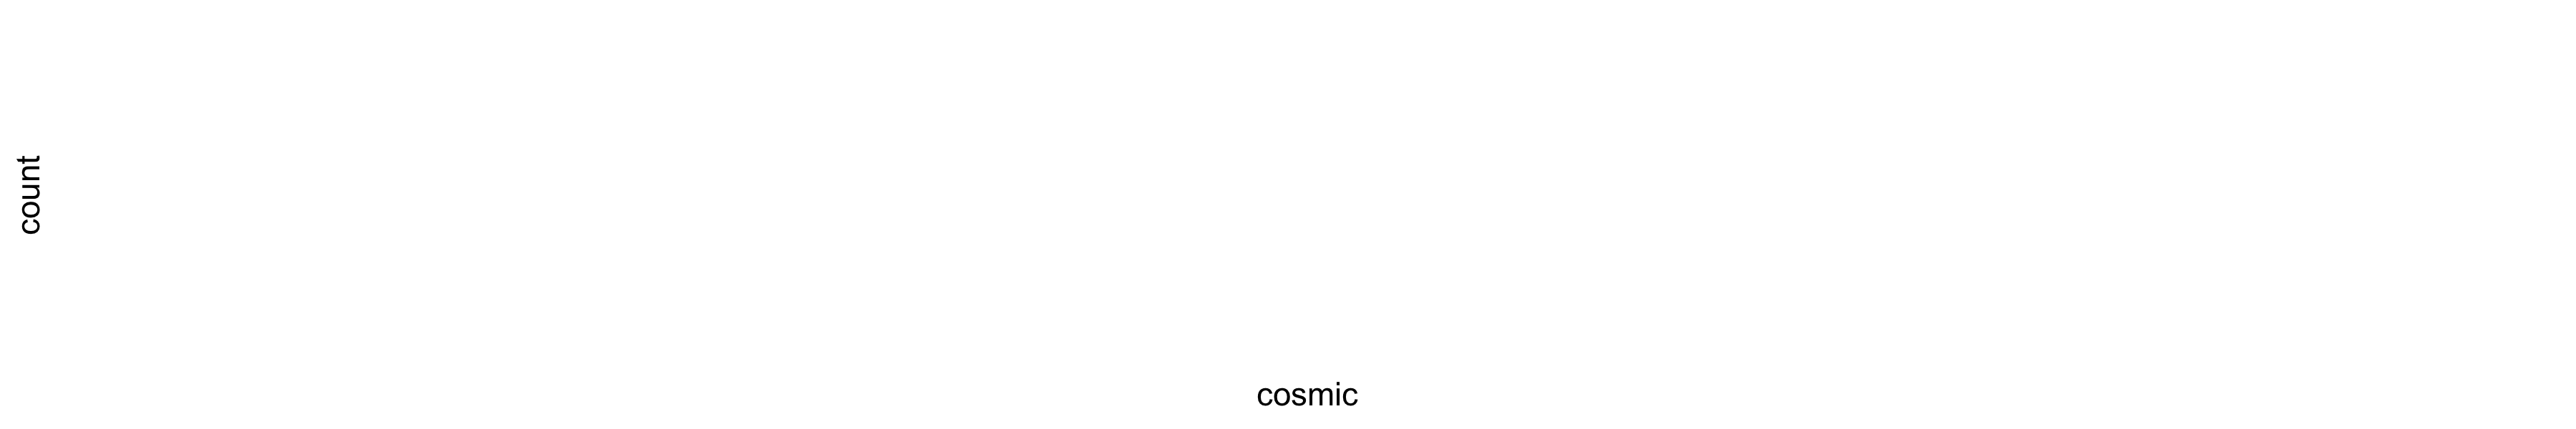

In [94]:
ggplot(impact_annotated[!is.na(impact_annotated$cosmic_count),]) + geom_bar(aes(cosmic))